In [46]:
import numpy as np

def calculate_manhattan_distance(current_pos,goal_pos):
	return abs(current_pos[0]-goal_pos[0])+abs(current_pos[1]-goal_pos[1])

def find_tile_position(grid,tile):
	row,col=np.where(grid==tile)
	return row[0],col[0]

def total_manhattan_distance(current_state):
	goal_state=np.arange(1,17).reshape(4,4)
	total_manhattan_distance=0
	for num in range(1,16):
		current_pos=find_tile_position(current_state,num)
		goal_pos=find_tile_position(goal_state,num)
		total_manhattan_distance+=calculate_manhattan_distance(current_pos,goal_pos)
	return total_manhattan_distance

In [47]:
import gymnasium as gym
from gymnasium.spaces import Discrete,Box,Dict
from gymnasium.utils import seeding

class FifteenPuzzleEnv(gym.Env):
	def __init__(self,config=None):
		self.current_steps=0
		self.action_space=Discrete(4)  # 0: left, 1: up, 2: right, 3: down
		self.grid_size=4
		self.observation_space=Box(low=0,high=self.grid_size-1,shape=(self.grid_size,),dtype=np.int32)
		self.seed()
		self.reset()

	def seed(self,seed=None):
		self.np_random,seed=seeding.np_random(seed)
		return [seed]

	def reset(self,seed=None,options=None):
		self._max_episode_steps=100
		self.current_steps=0
		self.state=np.arange(self.grid_size)
		self.np_random.shuffle(self.state)
		self.zero_pos=np.argwhere(self.state==0)[0]
		obs=self.state
		return obs,{}

	def step(self,action):
		self.current_steps+=1
		distance_1=total_manhattan_distance(self.state)
		valid_move=self.move(action)
		d=self.is_solved() or self.current_steps>=self._max_episode_steps
		distance_2=total_manhattan_distance(self.state)
		r=distance_1-distance_2
		if not valid_move:
			r-=5
		obs=self.state
		return obs,r,d,False,{}

	def move(self,action):
		new_zero_pos=np.array(self.zero_pos)
		if action==0:  # left
			new_zero_pos[1]-=1
		elif action==1:  # up
			new_zero_pos[0]-=1
		elif action==2:  # right
			new_zero_pos[1]+=1
		elif action==3:  # down
			new_zero_pos[0]+=1

		if (0<=new_zero_pos[0]<self.grid_size) and (0<=new_zero_pos[1]<self.grid_size):
			self.state[self.zero_pos[0],self.zero_pos[1]],self.state[new_zero_pos[0],new_zero_pos[1]]=(
				self.state[new_zero_pos[0],new_zero_pos[1]],
				self.state[self.zero_pos[0],self.zero_pos[1]],
			)
			self.zero_pos=new_zero_pos
			return True
		else:
			return False

	def is_solved(self):
		goal_state=np.arange(1,17).reshape((self.grid_size,self.grid_size))
		goal_state[3][3]=0
		return np.array_equal(self.state,goal_state)

In [48]:
env=FifteenPuzzleEnv()

In [49]:
env.reset()

({'position': array([3, 0]),
  'grid': array([[ 7, 11,  4,  9],
         [ 8,  1,  2, 14],
         [ 6, 13,  5, 12],
         [ 0, 10,  3, 15]])},
 {})

In [50]:
env.step(0)

({'position': array([3, 0]),
  'grid': array([[ 7, 11,  4,  9],
         [ 8,  1,  2, 14],
         [ 6, 13,  5, 12],
         [ 0, 10,  3, 15]])},
 -5,
 False,
 False,
 {})

In [ ]:
import ray
from ray import tune,air
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig
from ray.rllib.algorithms.callbacks import MemoryTrackingCallbacks
from ray.tune.logger import LoggerCallback
from ray.air import session
from ray.tune.registry import register_env

register_env("fp",FifteenPuzzleEnv)

class RewardLoggerCallback(LoggerCallback):
	def __init__(self) -> None:
		self.results=[]

	def log_trial_result(self,iteration: int,trial,result):
		self.results.append(result)

callback=RewardLoggerCallback()

stopping_criterion={"training_iteration":100}
ray.init(ignore_reinit_error=True,log_to_driver=False)
tuner=tune.Tuner(
	"DQN",
	param_space={
		"env":"fp",
		"framework":"torch",
		"num_gpus":1,
		"num_workers":18,
		"model":{
			"conv_filters":[
				[32,3,1],
				[64,3,1],
				[128,3,1],
			],

		},
	},
	run_config=air.RunConfig(
		stop=stopping_criterion,callbacks=[callback],
		checkpoint_config=air.CheckpointConfig(checkpoint_frequency=1),
	),
)
results=tuner.fit()
ray.shutdown()

2023-08-09 20:59:07,190	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-08-09 20:59:07,671	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-08-09 20:59:07,672	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-08-09 20:59:07,675	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/maml/maml.py` has been deprecated. Use `rllib_contrib/maml/` instead. This will raise an error in the future!


Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_total,training_iteration,trial_id
DQN_fp_86b09_00000,1008,{},"{'num_env_steps_sampled': 1008, 'num_env_steps_trained': 32, 'num_agent_steps_sampled': 1008, 'num_agent_steps_trained': 32, 'last_target_update_ts': 1008, 'num_target_updates': 1}",{},2023-08-09_20-59-15,False,nan,{},nan,nan,nan,0,0,home,"{'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'mean_q': -0.0009408624609932303, 'min_q': -0.017456362023949623, 'max_q': 0.009983371943235397, 'cur_lr': 0.0005}, 'model': {}, 'num_grad_updates_lifetime': 1.0, 'diff_num_grad_updates_vs_sampler_policy': 0.0, 'td_error': array([-1.0179287 , 1.0001464 , 0.9888821 , -1.0070841 , -1.0001776 , -1.0019795 , -1.0036741 , 0.99434537, 5.0000277 , 0.98634887, 0.99911815, 0.9970665 , -1.0018796 , -1.0153615 , -1.0025028 , -0.998718 , 4.9943695 , 4.990625 , -1.0054519 , 0.9968226 , 0.9977747 , -1.0005211 , -1.0112461 , 5.0000634 , 5.0001 , -1.0031964 , 1.0010873 , -1.0116462 , -1.0118088 , -0.9991431 , -1.0130438 , -0.99800175], dtype=float32), 'mean_td_error': 0.49510666728019714}}, 'num_env_steps_sampled': 1008, 'num_env_steps_trained': 32, 'num_agent_steps_sampled': 1008, 'num_agent_steps_trained': 32, 'last_target_update_ts': 1008, 'num_target_updates': 1}",1,192.168.0.121,1008,32,1008,1008,2147.29,32,32,68.1681,0,18,0,0,32,"{'cpu_util_percent': 53.5, 'ram_util_percent': 51.2, 'gpu_util_percent0': 0.01, 'vram_util_percent0': 0.15983072916666666}",25921,{},{},{},{},"{'episode_reward_max': nan, 'episode_reward_min': nan, 'episode_reward_mean': nan, 'episode_len_mean': nan, 'episode_media': {}, 'episodes_this_iter': 0, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [], 'episode_lengths': []}, 'sampler_perf': {}, 'num_faulty_episodes': 0, 'connector_metrics': {}}",0.474021,0.474021,0.474021,"{'training_iteration_time_ms': 11.601, 'sample_time_ms': 6.981, 'load_time_ms': 0.312, 'load_throughput': 102456.281, 'learn_time_ms': 5.79, 'learn_throughput': 5527.23, 'synch_weights_time_ms': 27.266}",1691585955,1008,1,86b09_00000


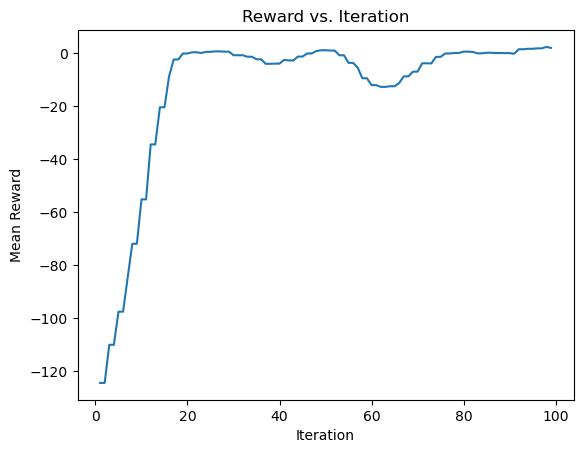

In [37]:
import matplotlib.pyplot as plt

rewards=[i["episode_reward_mean"] for i in callback.results]

plt.plot(rewards)
plt.xlabel("Iteration")
plt.ylabel("Mean Reward")
plt.title("Reward vs. Iteration")
plt.show()

In [38]:
results._experiment_analysis.trials

[DQN_fp_d5f4e_00000]

In [39]:
# Get the best result
best_result=results.get_best_result()

# Get the best checkpoint
best_checkpoint=best_result.checkpoint

In [40]:
len(results)

1

In [41]:
best_result

Result(
  metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'mean_q': 7.3733720779418945, 'min_q': 6.036434173583984, 'max_q': 9.18928050994873, 'cur_lr': 0.0005}, 'model': {}, 'num_grad_updates_lifetime': 5545.0, 'diff_num_grad_updates_vs_sampler_policy': 5544.0, 'td_error': array([-0.90943336, -0.54488945, -0.24522448, -0.32404995, -0.19506025,
       -0.67254686,  0.52847624, -0.7419033 ,  0.27373123,  0.7542076 ,
       -0.38305378, -0.37259054,  0.02908182,  0.0135293 ,  1.2016039 ,
        0.90147305, -0.14030504, -0.23417187, -0.14595652, -0.05315018,
        0.3555045 , -1.4146609 , -0.9725151 , -1.5343332 , -0.8353319 ,
       -1.1461372 , -0.00497103, -0.64868975, -0.05153656,  0.8858285 ,
       -0.51068354, -0.18714046], dtype=float32), 'mean_td_error': -0.22890309989452362}}, 'num_env_steps_sampled': 100800, 'num_env_steps_trained': 177440, 'num_agent_steps_sampled': 100800, 'num_agent_steps_

In [42]:
from ray.rllib.algorithms.algorithm import Algorithm

register_env("fp",FifteenPuzzleEnv)
algo=Algorithm.from_checkpoint(best_checkpoint)

/home/spacefarers/.local/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/spacefarers/.local/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/spacefarers/.local/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be remove

In [43]:
from time import sleep

obs=env.reset()[0]
progression=[]
done=False

In [44]:
obs

{'position': array([1, 3]),
 'grid': array([[15,  2,  1,  4],
        [ 8, 12, 14,  0],
        [10,  9, 11,  5],
        [13,  7,  6,  3]])}

In [45]:
from IPython.display import clear_output

while not done:
	action=algo.compute_single_action(obs)
	obs,reward,done,info,ads=env.step(action)
	print(action)
	print(reward)
	print(obs['grid'])
	sleep(0.2)
	clear_output(True)
# progression.append(obs)

2
1
[[ 2  1  4  5]
 [15 12 14  3]
 [ 8 10 11  6]
 [13  9  7  0]]


In [ ]:

for i in progression:
	print(i)
	sleep(1)
	clear_output(wait=True)